    lambda  Task        AA       AIA        FM        IM  Task 0 Acc
0        0     0  0.886000  0.886000  0.000000  0.000000    0.886000
1        0     1  0.836286  0.861143  0.162000 -0.006429    0.948571
2        0     2  0.815929  0.846071  0.168643 -0.033500    0.950500
3        0     3  0.802131  0.835086  0.172738 -0.027500    0.941667
4        0     4  0.821736  0.832416  0.147604 -0.018214    0.930357
5      500     0  0.886000  0.886000  0.000000  0.000000    0.886000
6      500     1  0.832786  0.859393  0.164000 -0.001429    0.943571
7      500     2  0.824905  0.847897  0.148429 -0.025000    0.942000
8      500     3  0.820440  0.841033  0.141881 -0.021667    0.935833
9      500     4  0.824157  0.837658  0.129065 -0.017500    0.929643
10    1000     0  0.886000  0.886000  0.000000  0.000000    0.886000
11    1000     1  0.836500  0.861250  0.143000  0.012143    0.930000
12    1000     2  0.780071  0.834190  0.204143 -0.015500    0.932500
13    1000     3  0.820125  0.8306

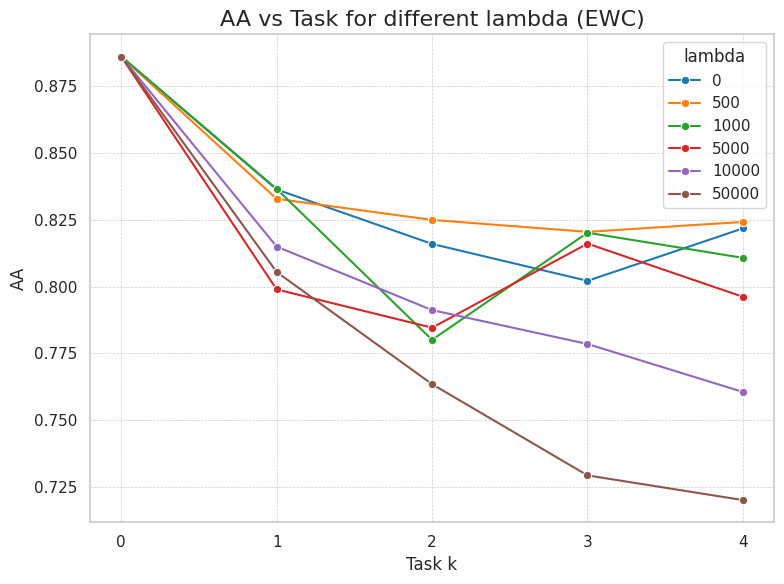

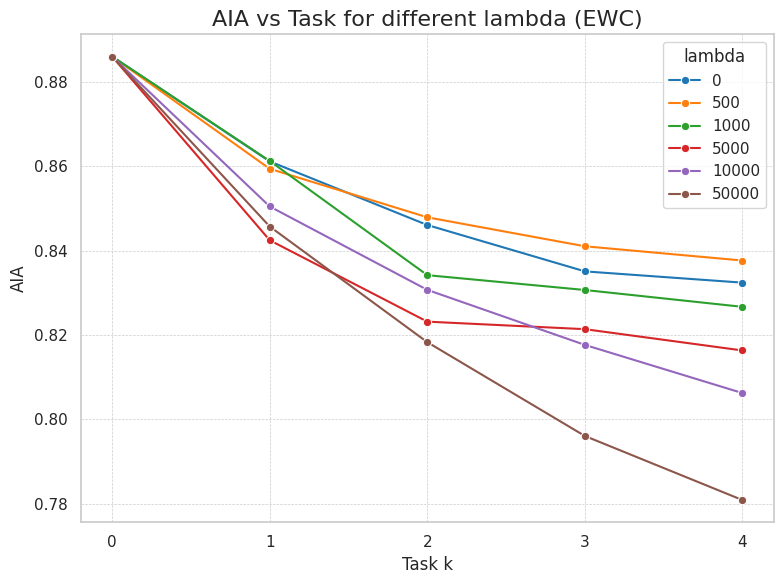

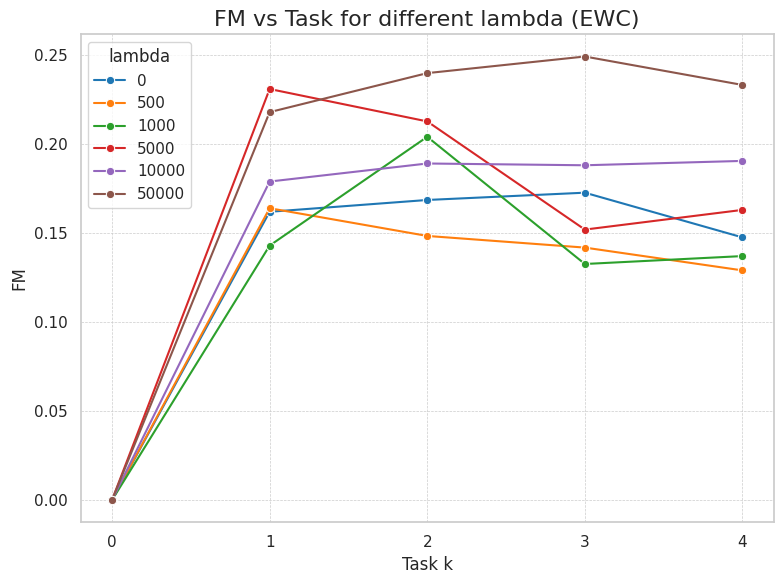

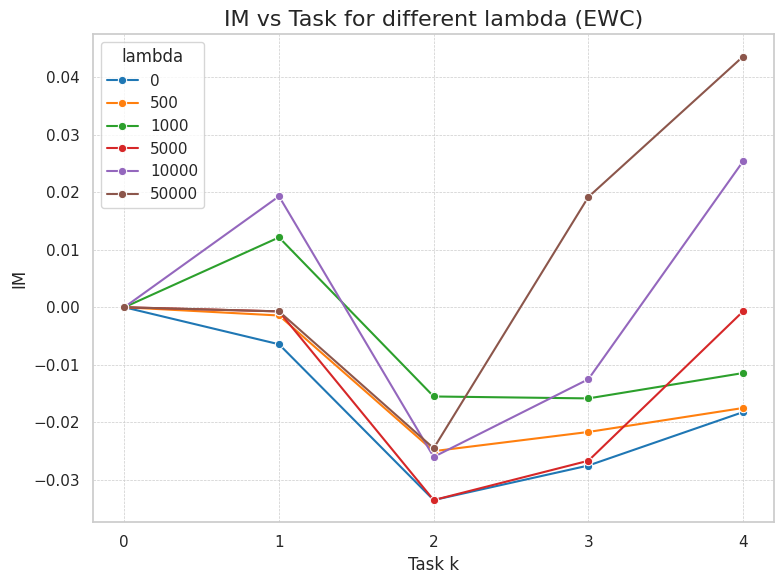

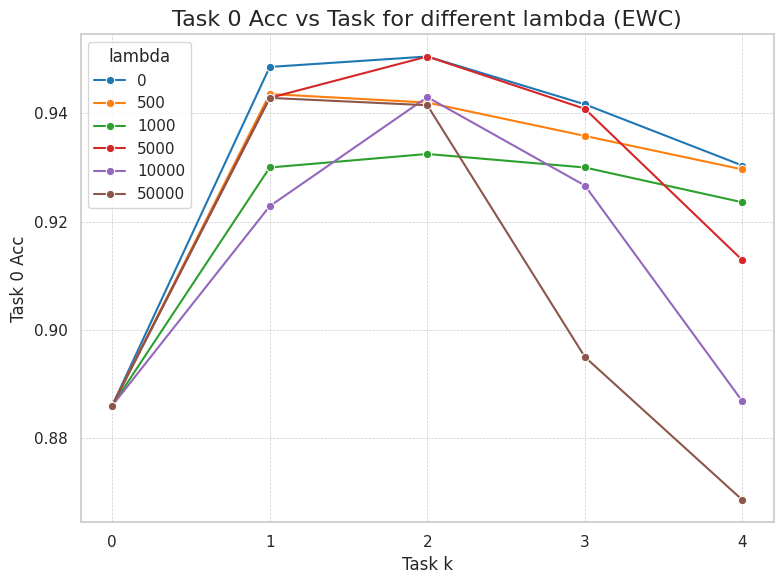

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. 指標計算関数 --- 

def compute_aa_and_aia(acc_matrix):
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs)/len(current_accs) if current_accs else 0
        AA_list.append(AA_k)
        AIA_k = sum(AA_list)/len(AA_list) if AA_list else 0
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix):
    fm_list = [0.0]
    num_tasks = len(acc_matrix)
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k) if j < len(acc_matrix[l])]
            max_past_acc = max(past_accs) if past_accs else 0
            current_acc = acc_matrix[k][j] if j < len(acc_matrix[k]) else 0
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum/k if k>0 else 0)
    return fm_list

def compute_im(acc_matrix, joint_accs):
    im_list = []
    num_tasks = len(acc_matrix)
    for k in range(num_tasks):
        if k < len(joint_accs) and k < len(acc_matrix[k]):
            im_list.append(joint_accs[k] - acc_matrix[k][k])
        else:
            im_list.append(np.nan)
    return im_list

# --- 2. CSV 読み込み & 指標計算 --- 

csv_dir = "/work/csv/uci-har/cil-ewc/"
joint_file_path = "/work/csv/uci-har/cil-joint/ltc_ncps.csv"
lambda_values = [0, 500, 1000, 5000, 10000, 50000]
num_tasks = 5

results = []

for lam in lambda_values:
    file_name = f"lambda{lam}.csv"
    file_path = os.path.join(csv_dir, file_name)
    
    if not os.path.exists(file_path):
        print(f"CSV not found: {file_path}")
        continue
    
    df = pd.read_csv(file_path)
    accuracies = df['テスト精度 (Test Acc)'].tolist()
    
    # acc_matrix を構築
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1

    # joint training の精度取得
    joint_accs = []
    if os.path.exists(joint_file_path):
        joint_df = pd.read_csv(joint_file_path)
        joint_accs = joint_df['テスト精度 (Test Acc)'].head(num_tasks).tolist()
    else:
        print(f"Joint training CSV not found: {joint_file_path}. IM will be NaN.")
    
    # 指標計算
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accs)
    
    # タスクごとに結果格納
    for k in range(num_tasks):
        results.append({
            'lambda': lam,
            'Task': k,
            'AA': aa_list[k],
            'AIA': aia_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Task 0 Acc': acc_matrix[k][k] 
        })

metrics_df = pd.DataFrame(results)
print(metrics_df)

# --- 3. 可視化 --- 

sns.set(style="whitegrid")
indicators = ["AA", "AIA", "FM", "IM", "Task 0 Acc"]

for ind in indicators:
    plt.figure(figsize=(8,6))
    sns.lineplot(data=metrics_df, x="Task", y=ind, hue="lambda", marker="o", palette="tab10")
    plt.title(f"{ind} vs Task for different lambda (EWC)", fontsize=16)
    plt.xlabel("Task k", fontsize=12)
    plt.ylabel(ind, fontsize=12)
    plt.xticks(range(num_tasks))
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(title="lambda")
    plt.tight_layout()
    plt.show()
